# Dar es Salaam

## Download data

In [1]:
import geopandas
import geopandas as gpd
import pandas as pd
import numpy as np
import pyrosm
import osmnx as ox
import momepy
import pygeos
import libpysal
import scipy
import networkx as nx
from tqdm import tqdm
import rioxarray
import xarray
import rasterstats
from download import download
import glob
import dask_geopandas
from shapely.geometry import box, mapping
from dask import dataframe as dd
from dask.system import cpu_count
from dask.distributed import Client, LocalCluster
import utils.momepy

import utils
from numpy import percentile
import os
import subprocess

from utils.momepy_utils import (
    _circle_radius,
    centroid_corner,
    elongation,
    get_corners,
    get_edge_ratios,
    get_nodes,
    solar_orientation_poly,
    squareness,
)

In [2]:
import warnings

warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

In [50]:
fua = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/ghs_fua_2015/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg")

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [51]:
fua_4326 = fua.to_crs(4326)
fua_4326.geometry = fua_4326.buffer(0)  # fix geometry topology

In [5]:
des_fua = polygon = fua_4326[fua_4326.eFUA_name == 'Dar es Salaam'].geometry.iloc[0]

### Street network

In [7]:
%%time
type_filter = '["highway"~"living_street|motorway|motorway_link|pedestrian|primary|primary_link|residential|secondary|secondary_link|service|tertiary|tertiary_link|trunk|trunk_link"]'

streets_graph = ox.graph_from_polygon(polygon, network_type='all_private', custom_filter=type_filter, retain_all=True)
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.highway = gdf.highway.astype(str)
path = f'../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/roads_osm.pq'
gdf[['highway', 'geometry']].to_parquet(path)

CPU times: user 2min 25s, sys: 1.27 s, total: 2min 26s
Wall time: 2min 42s


### Buildings

In [8]:
%time fp = pyrosm.get_data("tanzania", directory="../../urbangrammar_samba/sp_sig_concept/dar_es_salaam")

Downloaded Protobuf data 'tanzania-latest.osm.pbf' (464.53 MB) to:
'/home/jovyan/work/urbangrammar_samba/sp_sig_concept/dar_es_salaam/tanzania-latest.osm.pbf'
CPU times: user 1.42 s, sys: 1.77 s, total: 3.19 s
Wall time: 16.6 s


In [6]:
fp = '/home/jovyan/work/urbangrammar_samba/sp_sig_concept/dar_es_salaam/tanzania-latest.osm.pbf'

In [7]:
%time osm = pyrosm.OSM(fp)

CPU times: user 1.74 ms, sys: 658 µs, total: 2.4 ms
Wall time: 10.1 ms


In [15]:
%time buildings = osm.get_buildings()

CPU times: user 8min 48s, sys: 37.1 s, total: 9min 25s
Wall time: 9min 21s


In [16]:
%time dar = buildings.iloc[buildings.sindex.query(des_fua, predicate='intersects')]

CPU times: user 13.3 s, sys: 594 ms, total: 13.9 s
Wall time: 13.9 s


<AxesSubplot:>

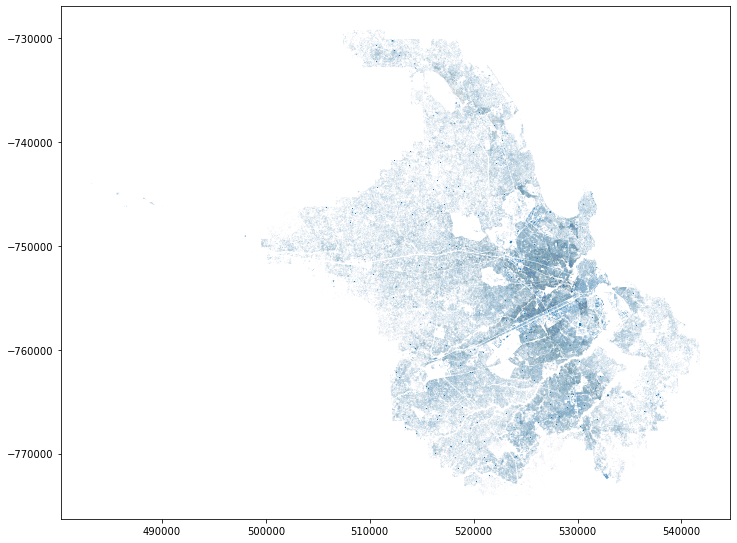

In [18]:
dar = dar.to_crs(gdf.crs)
dar.plot(figsize=(12, 12))

In [19]:
dar[['building', 'building:levels', 'geometry']].to_parquet('../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/footprints_osm.pq')

### Barriers

In [6]:
%%time
tags = {'natural': ['water', 'coastline', 'spring']}
gdf = ox.geometries_from_polygon(des_fua, tags)
path = f'../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/water_osm.pq'
gdf[['natural', 'geometry']].to_parquet(path)

CPU times: user 316 ms, sys: 45.3 ms, total: 361 ms
Wall time: 10.4 s


<timed exec>:4: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


In [8]:
%%time
tags = {'railway': True}
gdf = ox.geometries_from_polygon(des_fua, tags)
path = f'../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/railway_osm.pq'
gdf[['railway', 'geometry']].to_parquet(path)

CPU times: user 259 ms, sys: 12.5 ms, total: 271 ms
Wall time: 14.1 s


<timed exec>:4: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


## Data preprocessing

Building checks

In [4]:
buildings = gpd.read_parquet('../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/footprints_osm.pq')

In [5]:
buildings.geom_type.value_counts()

Polygon            1161335
MultiLineString         96
MultiPolygon            20
LineString               9
dtype: int64

In [9]:
buildings = buildings.reset_index(drop=True).explode().reset_index(drop=True)
buildings = buildings[buildings.geom_type == 'Polygon']

In [10]:
%time check = momepy.CheckTessellationInput(buildings)

Collapsed features  : 572
Split features      : 419
Overlapping features: 154
CPU times: user 1min 27s, sys: 2.1 s, total: 1min 29s
Wall time: 1min 27s


In [11]:
buildings = buildings.drop(check.collapse.index.union(check.overlap.index))

In [12]:
buildings.shape

(1160654, 3)

In [60]:
buildings.is_valid.all()

False

In [61]:
buildings.geometry = buildings.buffer(0)

In [62]:
buildings.is_valid.all()

True

In [13]:
buildings["uID"] = range(len(buildings))
%time buildings.to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/buildings.pq")

CPU times: user 2.04 s, sys: 243 ms, total: 2.28 s
Wall time: 3.36 s


In [41]:
roads = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/roads_osm.pq").to_crs(buildings.crs)

In [42]:
roads.geom_type.unique()

array(['LineString'], dtype=object)

In [43]:
railway = gpd.read_parquet('../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/railway_osm.pq').to_crs(buildings.crs)

In [44]:
railway.geom_type.unique()

array(['Point', 'LineString', 'Polygon'], dtype=object)

In [45]:
railway = railway[railway.geom_type == 'LineString']

In [46]:
extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

In [47]:
water = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/water_osm.pq").to_crs(buildings.crs)

In [48]:
coastline = water[water.geom_type =='LineString']

## Generate geography

### Enclosures

In [55]:
des_fua = fua_4326.to_crs(buildings.crs)[fua_4326.eFUA_name == 'Dar es Salaam']

In [56]:
%%time
enclosures = utils.momepy.enclosures(roads, limit=des_fua, additional_barriers=[extended_railway, coastline])

CPU times: user 9.17 s, sys: 2.16 ms, total: 9.17 s
Wall time: 9.17 s


<AxesSubplot:>

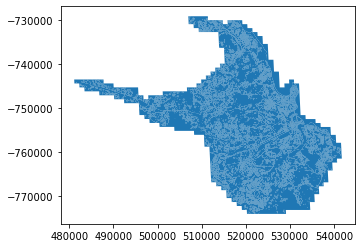

In [58]:
enclosures.plot()

In [63]:
enclosures.is_valid.all()

True

In [64]:
%%time
tess = utils.momepy.Tessellation(buildings, 'uID', enclosures=enclosures)

CPU times: user 8h 10min 33s, sys: 39min 38s, total: 8h 50min 11s
Wall time: 3h 14min 31s


In [65]:
tess.tessellation.to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/tessellation.pq")

In [66]:
enclosures.to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/enclosures.pq")

## Primary morphometric characters

In [36]:
# !pip install git+git://github.com/geopandas/geopandas.git

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-yno_dbwm
  Created wheel for geopandas: filename=geopandas-0.8.0+73.g1ef9242-py2.py3-none-any.whl size=973544 sha256=4725e193f05b223d15eab14ae701f25ce031fa786914e31f217511b95b55382e
  Stored in directory: /tmp/pip-ephem-wheel-cache-mozpnn91/wheels/37/ce/df/09721a3e578b57e217d038d0555fd872eba4e1fd9c8f6c8013
Successfully built geopandas
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.8.1
    Uninstalling geopandas-0.8.1:
      Successfully uninstalled geopandas-0.8.1


In [3]:
tess = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/tessellation.pq")
enclosures = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/enclosures.pq")
buildings = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/buildings.pq")

In [4]:
tess = tess.rename_geometry("tessellation").merge(buildings[['uID', 'geometry']].rename_geometry("buildings"), on='uID', how='left')

In [5]:
tess['tID'] = range(len(tess))
tess.head(5)

,uID,tessellation,eID,buildings,tID
0,784070.0,"POLYGON ((530753.667 -751662.183, 530753.915 -...",0,"POLYGON ((530671.226 -751656.231, 530671.497 -...",0
1,785052.0,"POLYGON ((530753.915 -751662.504, 530753.667 -...",0,"POLYGON ((530746.821 -751631.899, 530756.257 -...",1
2,785854.0,"POLYGON ((530710.355 -751642.103, 530709.850 -...",0,"POLYGON ((530680.755 -751609.597, 530694.811 -...",2
3,786074.0,"POLYGON ((530709.663 -751625.639, 530708.164 -...",0,"POLYGON ((530696.687 -751613.442, 530705.825 -...",3
4,786327.0,"POLYGON ((530744.095 -751637.861, 530744.095 -...",0,"POLYGON ((530727.804 -751594.126, 530743.086 -...",4


In [6]:
tess.shape

(1168896, 5)

In [7]:
tess.tessellation.geom_type.value_counts()

Polygon         1159492
MultiPolygon       9404
dtype: int64

In [8]:
client = Client(LocalCluster(n_workers=16))
client

Client Scheduler: tcp://127.0.0.1:44957 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 134.91 GB


In [9]:
warnings.filterwarnings('ignore', message='.*Assigning CRS to a GeoDataFrame without a geometry*')

In [10]:
ddf = dask_geopandas.from_geopandas(tess, npartitions=16)

In [11]:
%%time
## Measure morphometric characters
# Building area
ddf['sdbAre'] = ddf.buildings.area

# Building perimeter
ddf['sdbPer'] = ddf.buildings.length

# Courtyard area
exterior_area = ddf.buildings.map_partitions(lambda series: pygeos.area(pygeos.polygons(series.exterior.values.data)), meta='float')
ddf['sdbCoA'] = exterior_area - ddf['sdbAre']

# Circular compactness
hull = ddf.buildings.convex_hull.exterior

radius = hull.apply(lambda g: _circle_radius(list(g.coords)) if g is not None else None, meta='float')
ddf['ssbCCo'] = ddf['sdbAre'] / (np.pi * radius ** 2)

# Corners
ddf['ssbCor'] = ddf.buildings.apply(lambda g: get_corners(g), meta='float')

# Squareness
ddf['ssbSqu'] = ddf.buildings.apply(lambda g: squareness(g), meta='float')

# Equivalent rectangular index
bbox = ddf.buildings.apply(lambda g: g.minimum_rotated_rectangle if g is not None else None, meta=geopandas.GeoSeries())
ddf['ssbERI'] = (ddf['sdbAre'] / bbox.area).pow(1./2) * (bbox.length / ddf['sdbPer'])

# Elongation
ddf['ssbElo'] = bbox.map_partitions(lambda s: elongation(s), meta='float')

# Centroid corner mean distance and deviation
def _centroid_corner(series):
    ccd = series.apply(lambda g: centroid_corner(g))
    return pd.DataFrame(ccd.to_list(), index=series.index)


ddf[['ssbCCM', 'ssbCCD']] = ddf.buildings.map_partitions(_centroid_corner, meta=pd.DataFrame({0: [0.1], 1: [1.1]}))

# Solar orientation
ddf['stbOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Tessellation longest axis length
hull = ddf.tessellation.convex_hull.exterior

ddf['sdcLAL'] = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float') * 2

# Tessellation area
ddf['sdcAre'] = ddf.tessellation.area

# Circular compactness
radius = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float')
ddf['sscCCo'] = ddf['sdcAre'] / (np.pi * radius ** 2)

# Equivalent rectangular index
bbox = ddf.tessellation.apply(lambda g: g.minimum_rotated_rectangle, meta=geopandas.GeoSeries())
ddf['sscERI'] = (ddf['sdcAre'] / bbox.area).pow(1./2) * (bbox.length / ddf.tessellation.length)

# Solar orientation
ddf['stcOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Covered area ratio
ddf['sicCAR'] = ddf['sdbAre'] / ddf['sdcAre']

# Building-cell alignment
ddf['stbCeA'] = (ddf['stbOri'] - ddf['stcOri']).abs()

# Compute all characters using dask
df = ddf.compute()

CPU times: user 46.5 s, sys: 10.8 s, total: 57.2 s
Wall time: 7min 2s


In [13]:
df.to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/tess.pq")

In [20]:
%%time
# Load data
encl = dask_geopandas.from_geopandas(enclosures, npartitions=16)

# Area
encl['ldeAre'] = encl.geometry.area

# Perimeter
encl['ldePer'] = encl.geometry.length

# Circular compacntess
hull = encl.geometry.convex_hull.exterior

radius = hull.apply(lambda g: _circle_radius(list(g.coords)) if g is not None else None, meta='float')
encl['lseCCo'] = encl['ldeAre'] / (np.pi * radius ** 2)

# Equivalent rectangular index
bbox = encl.geometry.apply(lambda g: g.minimum_rotated_rectangle if g is not None else None, meta=geopandas.GeoSeries())
encl['lseERI'] = (encl['ldeAre'] / bbox.area).pow(1./2) * (bbox.length / encl['ldePer'])

# Compactness-weighted axis
longest_axis = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float') * 2
encl['lseCWA'] = longest_axis * ((4 / np.pi) - (16 * encl['ldeAre']) / ((encl['ldePer']) ** 2))

# Solar orientation
encl['lteOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Compute data and return geopandas.GeoDataFrame
encl_df = encl.compute()

# Weighted number of neighbors
inp, res = encl_df.sindex.query_bulk(encl_df.geometry, predicate='intersects')
indices, counts = np.unique(inp, return_counts=True)
encl_df['neighbors'] = counts - 1
encl_df['lteWNB'] = encl_df['neighbors'] / encl_df['ldePer']

# Measure weighted cells within enclosure
encl_counts = tess.groupby('eID').count()
merged = encl_df[['eID', 'ldeAre']].merge(encl_counts[['tessellation']], how='left', on='eID')
encl_df['lieWCe'] = merged['tessellation'] / merged['ldeAre']

CPU times: user 17.1 s, sys: 8.49 ms, total: 17.1 s
Wall time: 17 s


In [21]:
encl_df

,eID,geometry,ldeAre,ldePer,lseCCo,lseERI,lseCWA,lteOri,neighbors,lteWNB,lieWCe
0,0,"POLYGON ((530775.476 -751454.057, 530850.409 -...",5.367294e+04,924.270549,0.620365,1.013570,88.943718,37.032575,6,0.006492,0.000876
1,1,"POLYGON ((530850.409 -751543.997, 530775.476 -...",2.265035e+06,15431.931696,0.360360,0.398917,3171.416173,28.555919,101,0.006545,0.001324
2,2,"POLYGON ((530850.409 -751543.997, 530907.775 -...",5.003613e+04,1014.225324,0.371842,0.987864,204.874941,41.038963,8,0.007888,0.001979
3,3,"POLYGON ((530722.818 -751713.115, 530806.973 -...",3.050014e+04,892.699849,0.276935,0.933564,247.477416,14.397191,5,0.005601,0.002885
4,4,"POLYGON ((530533.808 -751619.705, 530623.211 -...",1.338792e+05,1801.482739,0.265853,0.964282,491.009943,8.094910,8,0.004441,0.000949
...,...,...,...,...,...,...,...,...,...,...,...
19923,19923,"POLYGON ((531621.072 -756221.064, 531617.995 -...",6.010534e+02,108.264387,0.438160,0.911133,18.922313,6.104658,7,0.064657,0.001664
19924,19924,"POLYGON ((512836.090 -764699.419, 512815.172 -...",4.538684e+04,1102.058066,0.361877,0.819973,269.867696,7.465657,11,0.009981,0.000771
19925,19925,"POLYGON ((520256.963 -771339.718, 520250.096 -...",1.620549e+04,533.407748,0.420748,1.045599,80.150423,10.149061,4,0.007499,0.000062
19926,19926,"POLYGON ((518951.769 -771594.281, 518935.993 -...",9.392840e+03,420.051024,0.429674,0.924339,70.318462,21.485445,5,0.011903,0.001490


In [22]:
# Save data to parquet
encl_df.to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/enclosures.pq")

### weights

In [3]:
cells = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/tess.pq")

In [4]:
cells.geometry.name

'tessellation'

In [6]:
%time w = libpysal.weights.Queen.from_dataframe(cells, geom_col='tessellation')
%time w3 = momepy.sw_high(k=3, weights=w)

CPU times: user 10min 54s, sys: 11.2 s, total: 11min 6s
Wall time: 11min 5s
CPU times: user 2min 2s, sys: 1.16 s, total: 2min 3s
Wall time: 2min 3s


NameError: name 'scipy' is not defined

NameError: name 'scipy' is not defined

In [8]:
%time scipy.sparse.save_npz(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/w_queen.npz", w.sparse)
%time scipy.sparse.save_npz(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/w3_queen.npz", w3.sparse)

CPU times: user 2.19 s, sys: 8.08 ms, total: 2.2 s
Wall time: 2.37 s
CPU times: user 21 s, sys: 40.1 ms, total: 21.1 s
Wall time: 21.4 s


In [10]:
df = cells

In [11]:
# alignment
def alignment(x, orientation='stbOri'):
    orientations = df[orientation].iloc[w.neighbors[x]]
    return abs(orientations - df[orientation].iloc[x]).mean()

df['mtbAli'] = [alignment(x) for x in range(len(df))]

# mean neighbour distance
def neighbor_distance(x):
    geom = df.buildings.iloc[x]
    if geom is None:
        return np.nan
    return df.buildings.iloc[w.neighbors[x]].distance(df.buildings.iloc[x]).mean()

df['mtbNDi'] = [neighbor_distance(x) for x in range(len(df))]

# weighted neighbours
df['mtcWNe'] = pd.Series([w.cardinalities[x] for x in range(len(df))], index=df.index) / df.tessellation.length

# area covered by neighbours
def area_covered(x, area='sdcAre'):
    neighbours = [x]
    neighbours += w.neighbors[x]

    return df[area].iloc[neighbours].sum()

df['mdcAre'] = [area_covered(x) for x in range(len(df))]

# read W3

# weighted reached enclosures
def weighted_reached_enclosures(x, area='sdcAre', enclosure_id='eID'):
    neighbours = [x]
    neighbours += w3.neighbors[x]

    vicinity = df[[area, enclosure_id]].iloc[neighbours]

    return vicinity[enclosure_id].unique().shape[0] / vicinity[area].sum()

df['ltcWRE'] = [weighted_reached_enclosures(x) for x in range(len(df))]

# mean interbuilding distance
# define adjacency list from lipysal
adj_list = w.to_adjlist(remove_symmetric=False)
adj_list["weight"] = (
    df.buildings.iloc[adj_list.focal]
    .reset_index(drop=True)
    .distance(df.buildings.iloc[adj_list.neighbor].reset_index(drop=True)).values
)




/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/conda/lib/python3.8/site-packages/pygeos/measurement.

NameError: name 'nx' is not defined

In [15]:
G = nx.from_pandas_edgelist(
        adj_list, source="focal", target="neighbor", edge_attr="weight"
    )
ibd = []
for i in range(len(df)):
    try:
        sub = nx.ego_graph(G, i, radius=3)
        ibd.append(np.nanmean([x[-1] for x in list(sub.edges.data('weight'))]))
    except:
        ibd.append(np.nan)

df['ltbIBD'] = ibd

# Reached neighbors and area on 3 topological steps on tessellation
df['ltcRea'] = [w3.cardinalities[i] for i in range(len(df))]
df['ltcAre'] = [df.sdcAre.iloc[w3.neighbors[i]].sum() for i in range(len(df))]

# Save cells to parquet keeping only within-chunk data not the additional neighboring
df.to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/tess.pq")

# Load street network for an extended chunk area
streets = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/roads_osm.pq").to_crs(df.crs)

<ipython-input-15-1a9916efc185>:8: RuntimeWarning: Mean of empty slice
  ibd.append(np.nanmean([x[-1] for x in list(sub.edges.data('weight'))]))


NameError: name 'street_profile' is not defined

In [19]:
# Street profile (measures width, width deviation and openness)
sp = momepy.StreetProfile(streets, df.set_geometry('buildings').buffer(0))
streets['sdsSPW'] = sp.w
streets['sdsSWD'] = sp.wd
streets['sdsSPO'] = sp.o

# Street segment length
streets['sdsLen'] = streets.length

# Street segment linearity
streets['sssLin'] = momepy.Linearity(streets).series

# Convert geopadnas.GeoDataFrame to networkx.Graph for network analysis
G = momepy.gdf_to_nx(streets)

# Node degree
G = momepy.node_degree(G)

# Subgraph analysis (meshedness, proportion of 0, 3 and 4 way intersections, local closeness)
G = momepy.subgraph(
    G,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
    verbose=False
)

# Cul-de-sac length
G = momepy.cds_length(G, radius=3, name="ldsCDL", verbose=False)

# Square clustering
G = momepy.clustering(G, name="xcnSCl")

# Mean node distance
G = momepy.mean_node_dist(G, name="mtdMDi", verbose=False)

# Convert networkx.Graph back to GeoDataFrames and W (denoting relationships between nodes)
nodes, edges, sw = momepy.nx_to_gdf(G, spatial_weights=True)

# Generate inclusive higher order weights
edges_w3 = momepy.sw_high(k=3, gdf=edges)

# Mean segment length
edges["ldsMSL"] = momepy.SegmentsLength(edges, spatial_weights=edges_w3, mean=True, verbose=False).series

# Generate inclusive higher order weights
nodes_w5 = momepy.sw_high(k=5, weights=sw)

# Node density
nodes["lddNDe"] = momepy.NodeDensity(nodes, edges, nodes_w5, verbose=False).series

# Weighter node density
nodes["linWID"] = momepy.NodeDensity(nodes, edges, nodes_w5, weighted=True, node_degree="degree", verbose=False).series

# Save to parquets
edges.to_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/edges.pq")
nodes.to_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/nodes.pq")

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.8/site-packages/momepy/dimension.py:626: RuntimeWarning: invalid value encountered in long_scalars
  openness.append(np.isnan(s).sum() / (f).sum())
/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2509 disconnected components.
  warnings.warn(message)


In [20]:
cells = df

In [21]:
cells['edgeID'] = get_edge_ratios(cells, edges)
cells['nodeID'] = get_nodes(cells, nodes, edges, 'nodeID', 'edgeID', 'node_start', 'node_end')

characters = ['sdsSPW', 'sdsSWD', 'sdsSPO', 'sdsLen', 'sssLin', 'ldsMSL']
l = []
for d in cells.edgeID:
    l.append((edges.iloc[list(d.keys())][characters].multiply(list(d.values()), axis='rows')).sum(axis=0))
cells[characters] = pd.DataFrame(l, index=cells.index)

cells = cells.merge(nodes.drop(columns=['geometry']), on='nodeID', how='left')
cells = cells.rename({'degree': 'mtdDeg', 'meshedness': 'lcdMes', 'proportion_3': 'linP3W', 'proportion_4': 'linP4W',
                 'proportion_0': 'linPDE', 'local_closeness': 'lcnClo'}, axis='columns')

cells['edgeID_keys'] = cells.edgeID.apply(lambda d: list(d.keys()))
cells['edgeID_values'] = cells.edgeID.apply(lambda d: list(d.values()))

cells.drop(columns='edgeID').to_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/tess.pq")


/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


In [3]:
enclosures = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/enclosures.pq")
cells = gpd.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/tess.pq")
nodes = gpd.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/nodes.pq")
edges = gpd.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/edges.pq")

In [4]:
cells = cells.merge(enclosures.drop(columns=['neighbors']), on='eID', how='left')

In [5]:
# Street Alignment
edges['orient'] = momepy.Orientation(edges, verbose=False).series
edges['edgeID'] = range(len(edges))
keys = cells.edgeID_values.apply(lambda a: np.argmax(a))
cells['edgeID_primary'] = [inds[i] for inds, i in zip(cells.edgeID_keys, keys)]
cells['stbSAl'] = momepy.StreetAlignment(cells, 
                                         edges, 
                                         'stbOri', 
                                         left_network_id='edgeID_primary', 
                                         right_network_id='edgeID').series

# Area Covered by each edge
vals = {x:[] for x in range(len(edges))}
for i, keys in enumerate(cells.edgeID_keys):
    for k in keys:
        vals[k].append(i)
area_sums = []
for inds in vals.values():
    area_sums.append(cells.sdcAre.iloc[inds].sum())
edges['sdsAre'] = area_sums

# Building per meter
bpm = []
for inds, l in zip(vals.values(), edges.sdsLen):
    bpm.append(cells.buildings.iloc[inds].notna().sum() / l if len(inds) > 0 else 0)
edges['sisBpM'] = bpm

# Cell area
nodes['sddAre'] = nodes.nodeID.apply(lambda nid: cells[cells.nodeID == nid].sdcAre.sum())

In [ ]:
# Area covered by neighboring edges + count of reached cells
edges_W = libpysal.weights.Queen.from_dataframe(edges, silence_warnings=True)

areas = []
reached_cells = []
for i in range(len(edges)):
    neighbors = [i] + edges_W.neighbors[i]
#     areas
    areas.append(edges.sdsAre.iloc[neighbors].sum())
#     reached cells
    ids = []
    for n in neighbors:
         ids += vals[n]
    reached_cells.append(len(set(ids)))

edges['misCel'] = reached_cells
edges['mdsAre'] = areas

# Area covered by neighboring (3 steps) edges + count of reached cells
edges_W3 = momepy.sw_high(k=3, weights=edges_W)

areas = []
reached_cells = []
for i in range(len(edges)):
    neighbors = [i] + edges_W3.neighbors[i]
#     areas
    areas.append(edges.sdsAre.iloc[neighbors].sum())
#     reached cells
    ids = []
    for n in neighbors:
         ids += vals[n]
    reached_cells.append(len(set(ids)))

edges['lisCel'] = reached_cells
edges['ldsAre'] = areas

# Link together 
e_to_link = ['sdsAre', 'sisBpM', 'misCel', 'mdsAre', 'lisCel', 'ldsAre']
n_to_link = 'sddAre'

cells = cells.merge(nodes[['nodeID', 'sddAre']], on='nodeID', how='left')

l = []
for keys, values in zip(cells.edgeID_keys, cells.edgeID_values):
    l.append((edges.iloc[keys][e_to_link].multiply(values, axis='rows')).sum(axis=0))  # weighted by the proportion
cells[e_to_link] = pd.DataFrame(l, index=cells.index)

In [ ]:
cells.shape

In [12]:
cells.to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/tess.pq")

In [10]:
edges.columns

Index(['highway', 'geometry', 'sdsSPW', 'sdsSWD', 'sdsSPO', 'sdsLen', 'sssLin',
       'mm_len', 'cdsbool', 'node_start', 'node_end', 'ldsMSL', 'orient',
       'edgeID', 'sdsAre', 'sisBpM', 'misCel', 'mdsAre', 'lisCel', 'ldsAre'],
      dtype='object')

In [11]:
cells.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'sdbAre', 'sdbPer',
       'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM',
       'ssbCCD', 'stbOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'stcOri',
       'sicCAR', 'stbCeA', 'mtbAli', 'mtbNDi', 'mtcWNe', 'mdcAre', 'ltcWRE',
       'ltbIBD', 'ltcRea', 'ltcAre', 'nodeID', 'sdsSPW', 'sdsSWD', 'sdsSPO',
       'sdsLen', 'sssLin', 'ldsMSL', 'mtdDeg', 'lcdMes', 'linP3W', 'linP4W',
       'linPDE', 'lcnClo', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID',
       'edgeID_keys', 'edgeID_values', 'geometry', 'ldeAre', 'ldePer',
       'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe',
       'edgeID_primary', 'stbSAl', 'sddAre', 'sdsAre', 'sisBpM', 'misCel',
       'mdsAre', 'lisCel', 'ldsAre'],
      dtype='object')

### Convolutions

Due to the extent of the data and memory demands, I am splitting the df into two parts.

In [3]:
characters = ['sdbAre', 'sdbPer',
       'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM',
       'ssbCCD', 'stbOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'stcOri',
       'sicCAR', 'stbCeA', 'mtbAli', 'mtbNDi', 'mtcWNe', 'mdcAre', 'ltcWRE',
       'ltbIBD', 'ltcRea', 'ltcAre', 'nodeID', 'sdsSPW', 'sdsSWD', 'sdsSPO',
       'sdsLen', 'sssLin', 'ldsMSL', 'mtdDeg', 'lcdMes', 'linP3W', 'linP4W',
       'linPDE', 'lcnClo', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID',
       'ldeAre', 'ldePer',
       'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe',
       'stbSAl', 'sddAre', 'sdsAre', 'sisBpM', 'misCel',
       'mdsAre', 'lisCel', 'ldsAre']

In [4]:
%%time 
data = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/tess.pq",
                        columns=characters + ["tessellation", "tID"]
                        )

CPU times: user 12.6 s, sys: 7.45 s, total: 20.1 s
Wall time: 39.9 s


In [5]:
bounds = data.total_bounds

In [6]:
data = data.set_index("tID")

In [7]:
tid = pd.Series(index=data.index, dtype="object", name="division")

In [8]:
centroids = data.centroid

In [9]:
x = np.mean([bounds[0], bounds[2]]) + 10000
y = np.mean([bounds[1], bounds[3]]) - 5000

In [10]:
sw = centroids.cx[:x, :y]
se = centroids.cx[x:, :y]
nw = centroids.cx[:x, y:]
ne = centroids.cx[x:, y:]

In [20]:
ne_bounds = ne.total_bounds
div = np.mean([ne_bounds[0], ne_bounds[2]]) - 5000
ne_a = ne.cx[:div, :]
ne_b = ne.cx[div:, :]

In [21]:
tid.loc[sw.index] = "sw"
tid.loc[se.index] = "se"
tid.loc[nw.index] = "nw"
tid.loc[ne_a.index] = "ne_a"
tid.loc[ne_b.index] = "ne_b"

In [22]:
tid.value_counts()

se      366589
nw      290483
ne_b    225568
sw      153615
ne_a    132641
Name: division, dtype: int64

In [23]:
pd.DataFrame(tid).to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/chunks.pq")

In [24]:
%%time
data.cx[:x + 1000, :y + 1000].to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/sw.pq")
data.cx[x - 1000:, :y + 1000].to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/se.pq")
data.cx[:x + 1000, y - 1000:].to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/nw.pq")
data.cx[x - 1000:, y - 1000:].cx[:div + 1000, :].to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/ne_a.pq")
data.cx[x - 1000:, y - 1000:].cx[div - 1000:, :].to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/ne_b.pq")

CPU times: user 9.77 s, sys: 2.15 s, total: 11.9 s
Wall time: 20.8 s


In [ ]:
# for chunk in ["sw", "se", "nw", "ne"]:    
for chunk in ["ne_a", "ne_b"]: 
    gdf = gpd.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/{chunk}.pq")
    W = momepy.sw_high(k=10, weights=libpysal.weights.Queen.from_dataframe(gdf, geom_col="tessellation"))
    gdf.geometry = gdf.centroid
    
    convolutions = {}
    for c in characters:
        convolutions[c] = []

    # measure convolutions
    for i, geom in tqdm(enumerate(gdf.geometry), total=gdf.shape[0]):
        neighbours = W.neighbors[i]
        vicinity = gdf.iloc[neighbours]
        distance = vicinity.distance(geom)
        distance_decay = 1 / distance

        for c in characters:
            values = vicinity[c].values
            sorter = np.argsort(values)
            values = values[sorter]
            sample_weight = distance_decay.values[sorter]
            weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
            weighted_quantiles /= np.sum(sample_weight)
            convolutions[c].append(np.interp([.25, .5, .75], weighted_quantiles, values))
    
    conv = pd.DataFrame(convolutions, index=gdf.index)
    exploded = pd.concat([pd.DataFrame(conv[c].to_list(), columns=[c + '_q1', c + '_q2',c + '_q3']) for c in characters], axis=1)
    exploded.to_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/convolutions_{chunk}.pq")
    print(f"{chunk} done.")

  6%|▌         | 13396/228660 [01:23<16:48, 213.52it/s] <ipython-input-25-dea0cc1ac726>:23: RuntimeWarning: invalid value encountered in subtract
  weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
<ipython-input-25-dea0cc1ac726>:24: RuntimeWarning: invalid value encountered in true_divide
  weighted_quantiles /= np.sum(sample_weight)
100%|██████████| 228660/228660 [19:27<00:00, 195.91it/s]


ne_a done.


100%|██████████| 291882/291882 [28:58<00:00, 167.90it/s] 


In [2]:
chunks = pd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/chunks.pq")

In [4]:
sw = pd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/convolutions_sw.pq")
se = pd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/convolutions_se.pq")
nw = pd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/convolutions_nw.pq")
ne_a = pd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/convolutions_ne_a.pq")
ne_b = pd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/convolutions_ne_b.pq")

In [9]:
sw_gdf = pd.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/sw.pq", columns=["tID"])

In [11]:
sw.index = sw_gdf.index

In [12]:
se_gdf = pd.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/se.pq", columns=["tID"])
nw_gdf = pd.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/nw.pq", columns=["tID"])
ne_a_gdf = pd.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/ne_a.pq", columns=["tID"])
ne_b_gdf = pd.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/ne_b.pq", columns=["tID"])

se.index = se_gdf.index
nw.index = nw_gdf.index
ne_a.index = ne_a_gdf.index
ne_b.index = ne_b_gdf.index

In [14]:
sw = sw.loc[sw.index.isin(chunks[chunks.division == "sw"].index)]
se = se.loc[se.index.isin(chunks[chunks.division == "se"].index)]
nw = nw.loc[nw.index.isin(chunks[chunks.division == "nw"].index)]
ne_a = ne_a.loc[ne_a.index.isin(chunks[chunks.division == "ne_a"].index)]
ne_b = ne_b.loc[ne_b.index.isin(chunks[chunks.division == "ne_b"].index)]

In [15]:
convolutions = pd.concat([sw, se, nw, ne_a, ne_b]).sort_index()

In [17]:
convolutions.to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/convolutions.pq")

In [ ]:
# !!!! remove nodeID from convolutions

### Functional data

#### Population

In [4]:
download("https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/TZA/tza_ppp_2020.tif",
        "../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/population/tza_ppp_2020.tif")


file_sizes: 100%|████████████████████████████| 485M/485M [00:44<00:00, 10.8MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/population/tza_ppp_2020.tif


'../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/population/tza_ppp_2020.tif'

In [13]:
data = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/tess.pq",
                        columns=["tessellation", "tID"]
                        )

In [4]:
pop = xarray.open_rasterio('../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/population/tza_ppp_2020.tif')

In [5]:
pop_proj = pop.rio.reproject(data.crs)
pop_clip = pop_proj.rio.clip_box(*data.total_bounds)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


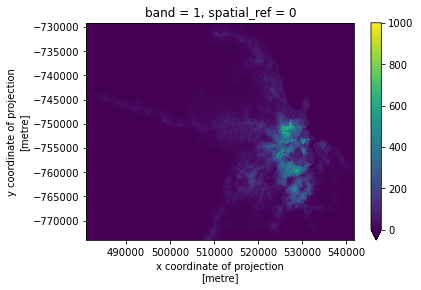

In [6]:
pop_clip.plot(vmin=0, vmax=1000)

In [7]:
pop_clip.rio.to_raster('../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/population/tza_ppp_2020_proj.tif')

In [8]:
arr = pop_clip.values
affine = pop_clip.rio.transform()

In [9]:
%%time 
stats = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
)

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


CPU times: user 15min 56s, sys: 33.7 s, total: 16min 30s
Wall time: 16min 30s


In [10]:
data['population'] = [x['mean'] for x in stats]

<AxesSubplot:>

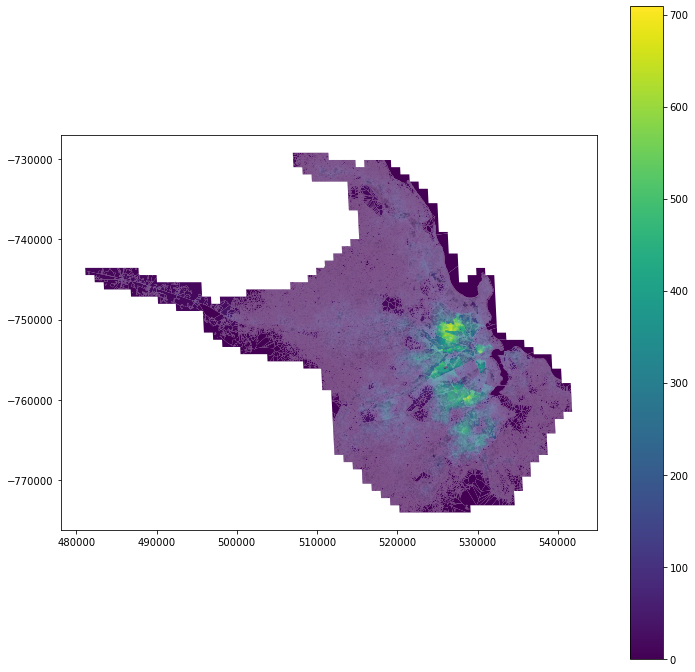

In [13]:
data.plot('population', figsize=(12, 12), legend=True, missing_kwds={"color": 'r'}, vmin=0)

In [11]:
mask = data.population < 0
data.population[mask] = 0

<ipython-input-11-2f3b25463834>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.population[mask] = 0


In [13]:
data[['tID', 'population']].to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/population/population.pq")

#### land cover

In [14]:
download("https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2019/E020N00/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif",
         "../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/land_cover/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif")


file_sizes: 100%|██████████████████████████| 95.6M/95.6M [00:03<00:00, 31.3MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/land_cover/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif


'../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/land_cover/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif'

In [3]:
lc = xarray.open_rasterio('../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/land_cover/E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif')

In [4]:
lc_proj = lc.rio.reproject(data.crs)
lc_clip = lc_proj.rio.clip_box(*data.total_bounds)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


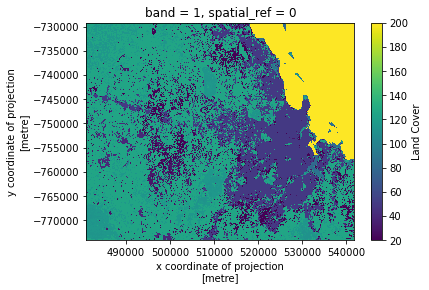

In [5]:
lc_clip.plot()

In [6]:
lc_clip

<xarray.DataArray (band: 1, y: 405, x: 549)>
array([[[116, 116, 116, ..., 200, 200, 200],
        [116, 116, 116, ..., 200, 200, 200],
        [126, 126, 114, ..., 200, 200, 200],
        ...,
        [116, 126, 126, ..., 126, 126, 126],
        [126, 126, 126, ..., 126, 116, 126],
        [126, 126, 126, ..., 126, 126, 126]]], dtype=uint8)
Coordinates:
  * x            (x) float64 4.811e+05 4.812e+05 ... 5.417e+05 5.418e+05
  * y            (y) float64 -7.293e+05 -7.294e+05 ... -7.739e+05 -7.741e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scales:                       (1.0,)
    offsets:                      (0.0,)
    archive_facility:             VITO NV
    AREA_OR_POINT:                Area
    copyright:                    Copernicus Service information 2020
    creator:                      Dr. Marcel Buchhorn (VITO)
    delivered_product_crs:        WGS84 (EPSG:4326)
    delivered_product_grid:       global 20x20 deg tiling grid
    delivered_product_tile_name:  E020N00
    doi:                          10.5281/zenodo.3939050
    file_creation:                Mon Jul 13 20:02:35 2020
    history:                      2020-07-10 Processing line LC100 v4.1
    Info:                         E020N00 for product Discrete-Classification...
    institution:                  VITO NV
    long_name:                    Land Cover
    NODATA_value:                 255
    orbit_type:                   LEO
    platform:                     Proba-V
    processing_level:             L3
    processing_mode:              Offline
    production_crs:               UTM
    production_grid:              MGRS (Sentinel-2 tiling grid)
    product_version:              v3.0.1
    references:                   https://land.copernicus.eu/global/products/lc
    region_name:                  global
    sensor:                       VEGETATION
    source:                       Derived from EO satellite imagery
    time_coverage_end:            2020-03-31T23:59:59Z
    time_coverage_start:          2017-04-01T00:00:00Z
    time_reference_year:          2019
    title:                        Dynamic Land Cover Map 100m 2019-nrt
    grid_mapping:                 spatial_ref
    _FillValue:                   255

In [9]:
arr = lc_clip.values
affine = lc_clip.rio.transform()

In [10]:
arr.shape

(1, 405, 549)

In [12]:
%%time 
stats_use = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['majority'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 16min 25s, sys: 34.8 s, total: 17min
Wall time: 17min


In [13]:
data['land_cover'] = [x['majority'] for x in stats_use]

<AxesSubplot:>

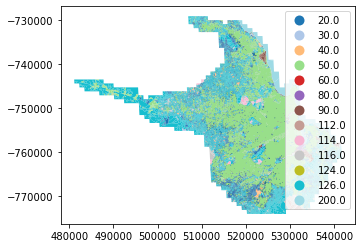

In [20]:
data.plot("land_cover", categorical=True, legend=True, cmap='tab20')

In [21]:
data[["land_cover", "tID"]].to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/land_cover/land_cover.pq")

### night lights

From https://eogdata.mines.edu/download_dnb_composites.html.

Requires login. Downloaded manually.

In [2]:
download("https://www.dropbox.com/s/z6zmjo4qpgzu4ii/SVDNB_npp_20200601-20200630_00N060W_vcmcfg_v10_c202008012300.tgz?dl=1",
         "../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/night_lights", kind="tar.gz", replace=True)

Extracting tar.gz file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/night_lights


'../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/night_lights'

In [11]:
nl = xarray.open_rasterio('../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/night_lights/SVDNB_npp_20200601-20200630_00N060W_vcmcfg_v10_c202008012300.avg_rade9h.tif')

In [14]:
from shapely.geometry import box

bounds = gpd.GeoSeries(box(*data.total_bounds), crs=data.crs).to_crs(nl.crs)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [15]:
nl_clip = nl.rio.clip_box(*bounds.total_bounds)
nl_proj = nl_clip.rio.reproject(data.crs)

In [16]:
arr = nl_proj.values
affine = nl_proj.rio.transform()

In [17]:
%%time 
stats_nl = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 15min 51s, sys: 34.7 s, total: 16min 26s
Wall time: 16min 26s


In [18]:
data['lights'] = [x['mean'] for x in stats_nl]

<AxesSubplot:>

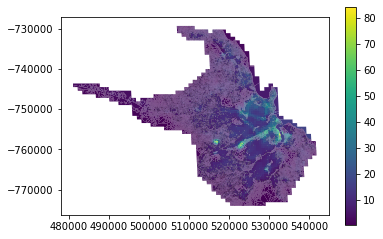

In [19]:
data.plot("lights", legend=True)

In [20]:
data[["lights", "tID"]].to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/night_lights/night_lights.pq")

### NDVI

In [2]:
local_dir = "../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/"

In [3]:
tiles = geopandas.read_file("../../data_processing/imagery/GHS-composite-S2.geojson")

In [4]:
dar_es_salaam = geopandas.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/nodes.pq")

In [5]:
dar_es_salaam_extent = geopandas.GeoSeries(box(*dar_es_salaam.total_bounds), crs=dar_es_salaam.crs).to_crs(tiles.crs).iloc[0]

In [9]:
meta = tiles[tiles.intersects(dar_es_salaam_extent)]
meta["dst_path"] = meta["URL"].apply(lambda x: local_dir+x.split("/")[-1])
dar_es_salaam.crs

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<Projected CRS: PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["Wor ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 37N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
out = meta.iloc[[0]].apply(utils.process_scene, 
                   axis=1,
                   t_crs="EPSG:32637",
                   progressbar=True,
                  )

14/01/2021 14:57:19 | Working on Tile 37M - File: S2_percentile_UTM_636-0000069888-0000023296.tif

file_sizes: 100%|██████████████████████████| 2.28G/2.28G [01:33<00:00, 24.5MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296.tif
	14/01/2021 14:58:53 | rio warp ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296.tif ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296_osgb.tif --threads 16 --dst-crs EPSG:32637
	14/01/2021 15:04:09 | rm ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296.tif
	Split-opt.
		14/01/2021 15:06:00 | Optimising S2_percentile_UTM_636-0000069888-0000023296_wm_R.tif
		14/01/2021 15:08:31 | Optimising S2_percentile_UTM_636-0000069888-0000023296_wm_G.tif
		14/01/2021 15:10:59 | Optimising S2_percentile_UTM_636-0000069888-0000023296_wm_B

KeyboardInterrupt: 

In [11]:
r = rioxarray.open_rasterio("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296_osgb.tif")

In [17]:
sub = r.sel(band=[1, 2, 3]).rio.clip_box(*dar_es_salaam.total_bounds)

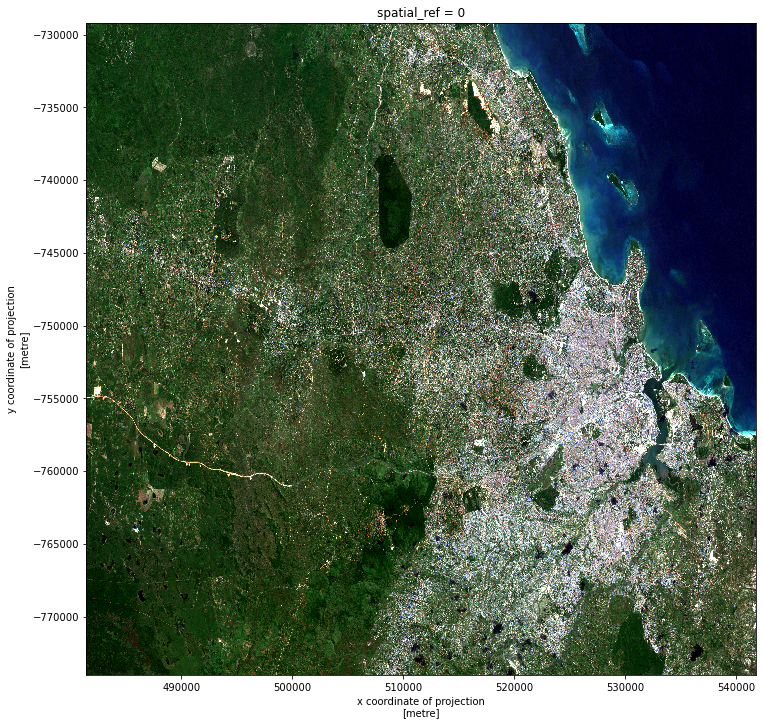

In [18]:
sub.groupby("band")\
   .map(minmax)\
   .plot.imshow(figsize=(12, 12));

In [14]:
dar_es_salaam = geopandas.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/tessellation.pq")
r = rioxarray.open_rasterio("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296_osgb.tif")

In [15]:
dar_es_salaam.crs.equals(r.rio.crs)

True

In [16]:
clipped = r.rio.clip_box(*dar_es_salaam.total_bounds)
masked = clipped.where(clipped != 0)

In [17]:
ndvi = (masked.sel(band=4) - masked.sel(band=1)) / (masked.sel(band=4) + masked.sel(band=1))

In [18]:
ndvi.min(), ndvi.max()

(<xarray.DataArray ()>
 array(-0.66080225)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray ()>
 array(0.85430464)
 Coordinates:
     spatial_ref  int64 0)

In [19]:
affine = ndvi.rio.transform()

In [20]:
%%time
stats = rasterstats.zonal_stats(
    dar_es_salaam.geometry, 
    raster=ndvi.values,
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 28min 54s, sys: 1min 7s, total: 30min 1s
Wall time: 30min 1s


In [21]:
dar_es_salaam['ndvi'] = [x["mean"] for x in stats]

In [23]:
dar_es_salaam

,uID,geometry,eID,ndvi
0,784070.0,"POLYGON ((530753.667 -751662.183, 530753.915 -...",0,0.137347
1,785052.0,"POLYGON ((530753.915 -751662.504, 530753.667 -...",0,0.230215
2,785854.0,"POLYGON ((530710.355 -751642.103, 530709.850 -...",0,0.277036
3,786074.0,"POLYGON ((530709.663 -751625.639, 530708.164 -...",0,0.389978
4,786327.0,"POLYGON ((530744.095 -751637.861, 530744.095 -...",0,0.372431
...,...,...,...,...
1168891,NaN,"POLYGON ((531621.072 -756221.064, 531623.115 -...",19920,0.413103
1168892,NaN,"POLYGON ((531623.115 -756235.533, 531621.072 -...",19921,0.470519
1168893,NaN,"POLYGON ((531617.995 -756192.298, 531621.072 -...",19922,0.498046
1168894,NaN,"POLYGON ((531621.072 -756221.064, 531617.995 -...",19923,0.492762


In [24]:
dar_es_salaam[["ndvi"]].to_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/ndvi.pq")

<AxesSubplot:>

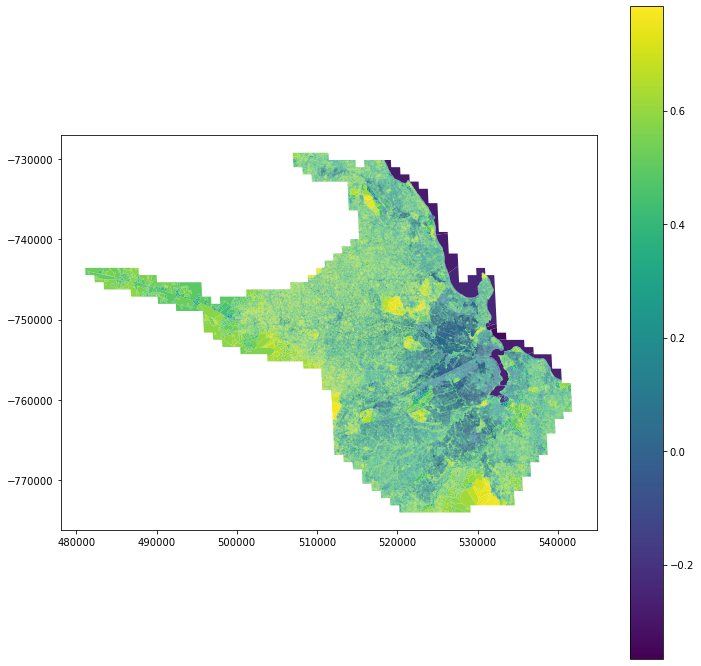

In [25]:
dar_es_salaam.plot('ndvi', legend=True, figsize=(12, 12))